### Preparation - Review raw usage data

In [2]:
del df_raw

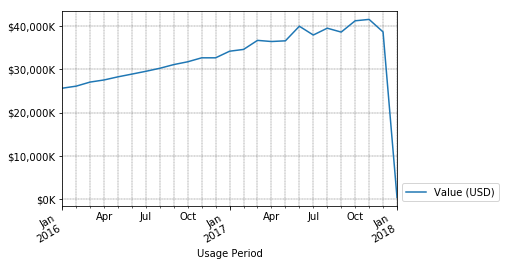

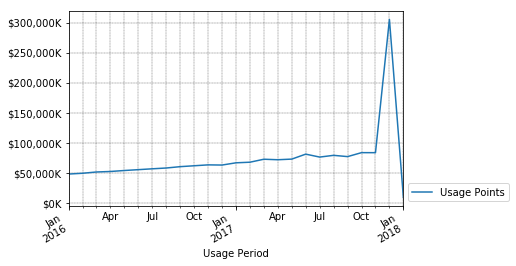

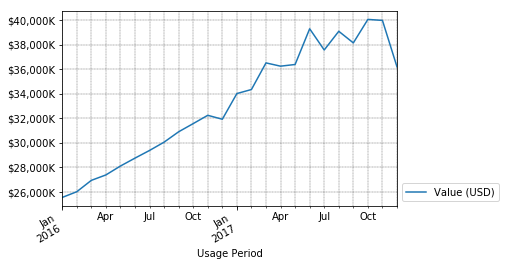

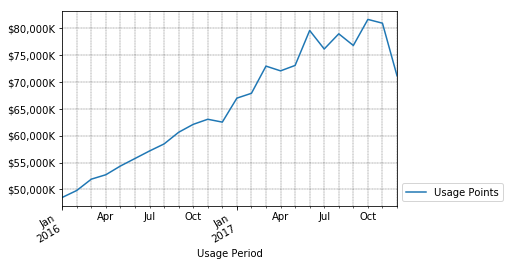

Index(['Aggregator', 'Aggregator Partner ID', 'Service Provider',
       'SP Partner ID', 'Contract No', 'Contract Size', 'Collected Point',
       'Base Price', 'Overage Price', 'Currency', 'GEO', 'Country',
       'Country Code', 'State', 'City', 'Postcode', 'Product Family',
       'Product', 'SKU', 'Units Utilised', 'Usage Points', 'Site Name',
       'Site Country', 'Site Postcode', 'Site Units Utilised',
       'Site Usage Points', 'Value', 'Value (USD)', 'Restricted Product',
       'Usage Period', 'Date Submitted', 'Collection Status',
       'Contract Usage Token', 'Contract Token', 'FX to USD', 'Was in Grace',
       'Partner Group Name', 'Partner Status', 'Product Group', 'NewQuarters',
       'Region', 'Avg VM Count', 'Avg Tenant Count', 'Product Category',
       'Contract Group'],
      dtype='object')


In [82]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from plot_helper import *

CSV_FILE = '../data/GlobalUsageReport.csv'
CSV_FILE_LATEST = '../data/GlobalUsageReport_Latest.csv'

try:
    df_raw
except NameError:
    df_raw = pd.read_csv(CSV_FILE,encoding="ISO-8859-1",parse_dates=['Usage Period'])#
#    df_raw_latest = pd.read_csv(CSV_FILE_LATEST,encoding="ISO-8859-1",parse_dates=['Usage Period'])
#    df_raw = pd.concat([df_raw,df_raw_latest]).drop_duplicates(subset=['Service Provider','Usage Period','SKU','Contract No'],keep='first')

df_raw.groupby('Usage Period')['Value (USD)'].sum().plot()
format_trend_chart()
plt.show()

df_raw.groupby('Usage Period')['Usage Points'].sum().plot()
format_trend_chart()
plt.show()

df_rental = df_raw[(df_raw['Product Family'] == 'Rental') &
                   ((df_raw['Collection Status'] == 'Closed') |
                    (df_raw['Collection Status'] == 'Pending Agg') |
                    (df_raw['Collection Status'] == 'Pending Vendor')                    
                   )]

df_rental.groupby('Usage Period')['Value (USD)'].sum().plot()
format_trend_chart()
plt.show()

df_rental.groupby('Usage Period')['Usage Points'].sum().plot()
format_trend_chart()
plt.show()

print(df_raw.columns)


### Preparation - Configure QUARTER_RANGE in defines.py

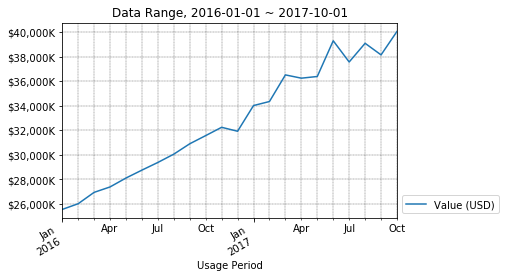

In [86]:
from defines import *


df = df_rental[(df_rental['Usage Period']<=END_MONTH) & 
               (df_rental['Usage Period']>=START_MONTH)]

df.groupby('Usage Period')['Value (USD)'].sum().plot()
format_trend_chart()
plt.title("Data Range, {} ~ {}".format(START_MONTH,END_MONTH))
plt.show()



### MoM Point Growth

In [ ]:
def print_mom_growth(s):
    for i,d in enumerate((s/s.shift(1)-1)*100):
        print('---') if s.index[i].month % 3 == 2 else None
        print('{:%b %Y} {:6.2f}%'.format(s.index[i],d))

def s_usage_point(df,g='ALL'):
    if g != 'ALL':
        df = df[df['Partner Group Name']==g]
    return df.groupby('Usage Period')['Usage Points'].sum()

# print_mom_growth(s_usage_point(df))
print('NTT')
print_mom_growth(s_usage_point(df,g='NTT'))
print('Fujitsu')
print_mom_growth(s_usage_point(df,g='Fujitsu'))




### Total VCPP Revenue & Parnter Cound Trend

In [ ]:
from functools import reduce

plt.close()
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

rev = df.groupby('Usage Period')['Value (USD)'].sum()
ax1.bar(rev.index,rev.values,10,label='Total Revenue')

cnt = df.groupby('Usage Period')['Service Provider'].unique()
pcnts = list(map(lambda x: len(x), cnt.values))
ax2.plot(cnt.index,pcnts,'o-',c='tomato',label='Partner Count')
ax2.set_ylim(bottom=3500,top=3500*rev.values.max()/rev.values.min())
ax2.set_ylabel('vCAN Partner Count')
ax2.legend(loc="lower right", bbox_to_anchor=(1,0.1))
    
x0=len(cnt.loc[END_MONTH.replace(year=END_MONTH.year-1)])
x1=len(cnt.loc[END_MONTH])
print("YoY Partner Count Growth: +{:.0f}%".format((x1/x0-1)*100))

x0=reduce(lambda x,y:x+y,map(lambda x: rev.loc[x],map(lambda x: x.replace(year=x.year-1),END_QUARTER)))
x1=reduce(lambda x,y:x+y,map(lambda x: rev.loc[x],END_QUARTER))
VCPP_REV_GROWTH = x1/x0-1 
print("YoY Quarter Revenue Growth : +{:.0f}%".format(VCPP_REV_GROWTH*100))

ax1.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
ax1.set_yticklabels(['${:,.0f}K'.format(x/1000) for x in ax1.get_yticks()])
ax1.set_ylabel('vCAN Total MRR')
ax1.legend(loc="lower right", bbox_to_anchor=(1,0))

fig = plt.gcf()
fig.autofmt_xdate() 
plt.title("VCPP Revenue & Partner Count")
fig.set_size_inches(10,6)
plt.show()

### Price per Point Trend

In [ ]:
def plot_dist(d,caption=''):
    pp = d['Value (USD)']/d['Usage Points']

    pp.plot.hist(bins=10)
    plt.minorticks_on()
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.xlim([0,1.0])
    plt.title("Point Price Distribution {}(Average={:.2f})".format(caption,pp.mean()))
    plt.show()

_df = df[df['Usage Points'] > 0]
_df_fujitsu = _df[_df['Partner Group Name']=='Fujitsu'].copy()

plot_dist(_df)
plot_dist(_df_fujitsu,caption=' - Fujitsu ')

def point_price_trend(sp):
    _df_sp = _df[_df['Service Provider']==sp].copy()
#    _df_sp = _df[_df['Partner Group Name']==sp].copy()
    _df_sp.loc[:,'Point Price'] = pd.Series(_df_sp['Value (USD)']/_df_sp['Usage Points'],index=_df_sp.index)

    _df_sp.groupby('Usage Period')['Point Price'].max().plot()
    plt.ylabel('Point Price')
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.gca().yaxis.grid(True, which='both',linestyle='dashed')
    plt.title('Point Price Trend - {}'.format(sp))
    plt.show()
    

point_price_trend('NTT Communications Corporation')
point_price_trend('Fujitsu Limited (Japan)')





### Showcase Partner Monthly Revenue Trend

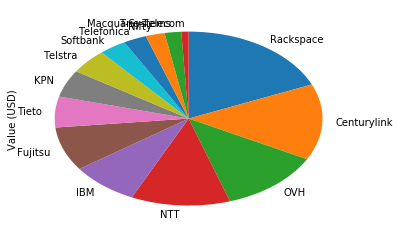

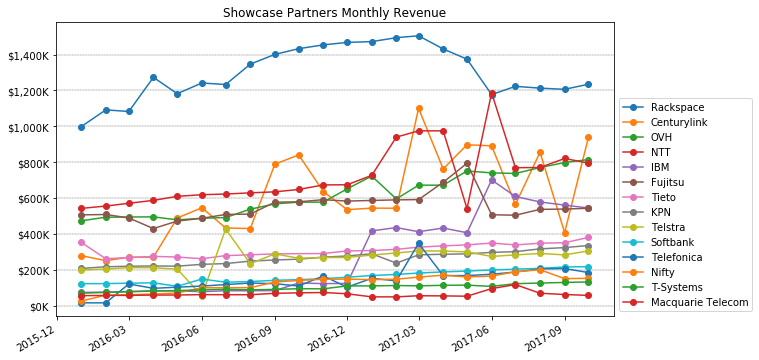

In [87]:
showcase_partners = df[(df['Usage Period'] == END_MONTH) &
                       (df['Partner Status'] == 'Showcase')].groupby('Partner Group Name')['Value (USD)'].sum().sort_values(ascending=False)

showcase_partners.plot.pie(startangle=90,counterclock=False)
plt.show()

for partner in showcase_partners.index:
    partner_rev = df[df['Partner Group Name'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    plt.plot(partner_rev.index,partner_rev.values,'o-',label=partner)

format_trend_chart()

plt.title("Showcase Partners Monthly Revenue")
plt.gcf().set_size_inches(10,6)
plt.show()



### Showcase Partner Growth Trend

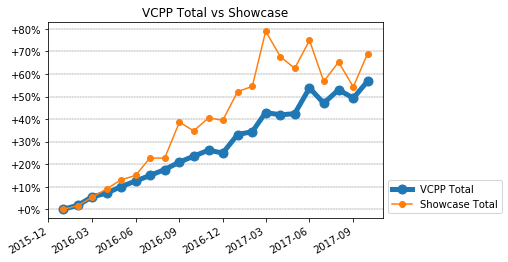

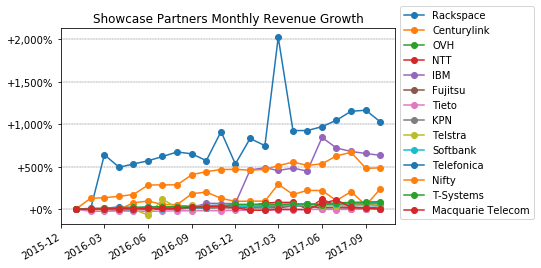

In [88]:
def plot_rev_trend(l,data,thick=False):
    if thick:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l,linewidth=5.0,markersize=9.0)
    else:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l)

def plot_partner(partner):
    plot_rev_trend(partner,df[df['Partner Group Name']==partner].groupby('Usage Period')['Value (USD)'].sum())

def format_chart(title):
    ax = format_trend_chart()
    ax.set_yticklabels(['+{:,.0f}%'.format(x) for x in ax.get_yticks()])
 #   ax.legend(loc="lower right", bbox_to_anchor=(1,0))
    plt.title(title)

plot_rev_trend('VCPP Total',df.groupby('Usage Period')['Value (USD)'].sum(),True)
plot_rev_trend('Showcase Total',df[df['Partner Status']=='Showcase'].groupby('Usage Period')['Value (USD)'].sum())
format_chart('VCPP Total vs Showcase')
plt.show()

for sp in showcase_partners.index:
    plot_partner(sp)
 
format_chart("Showcase Partners Monthly Revenue Growth")
plt.show()


In [ ]:
df_f = df[df['Partner Group Name']=='Fujitsu']
df_f_h = df_f[df_f['Product'].str.match(r'.*Horizon.*')]

total = df_f.groupby('Usage Period')['Value (USD)'].sum()
horizon = df_f_h.groupby('Usage Period')['Value (USD)'].sum()

plt.bar(total.index,horizon.values,20,label='Horizon')
plt.bar(total.index,total.values-horizon.values,20,label='Total',bottom=horizon.values)

format_trend_chart()
plt.title('Fujitsu Horizon Revenue Contribution')
plt.show()
    
#(df['Product Group']=='Horizon']


Rackspace                                United States    (AMER) $   480,992 (15%)
NTT                                      United States    (AMER) $   717,094 (43%)
OVH                                      France           (EMEA) $   921,943 (63%)
Centurylink                              United States    (AMER) $ 1,401,179 (175%)
IBM                                      United States    (AMER) $ 1,454,658 (632%)
Fujitsu                                  Japan            (APAC) $   115,308 (8%)
Tieto                                    Finland          (EMEA) $   196,653 (22%)
KPN                                      Netherlands      (EMEA) $   331,376 (51%)
Telstra                                  Australia        (APAC) $   264,685 (43%)
Softbank                                 Japan            (APAC) $   270,247 (73%)
Telefonica                               Spain            (EMEA) $   443,923 (288%)
Nifty                                    Japan            (APAC) $   358,274 (244%)
T

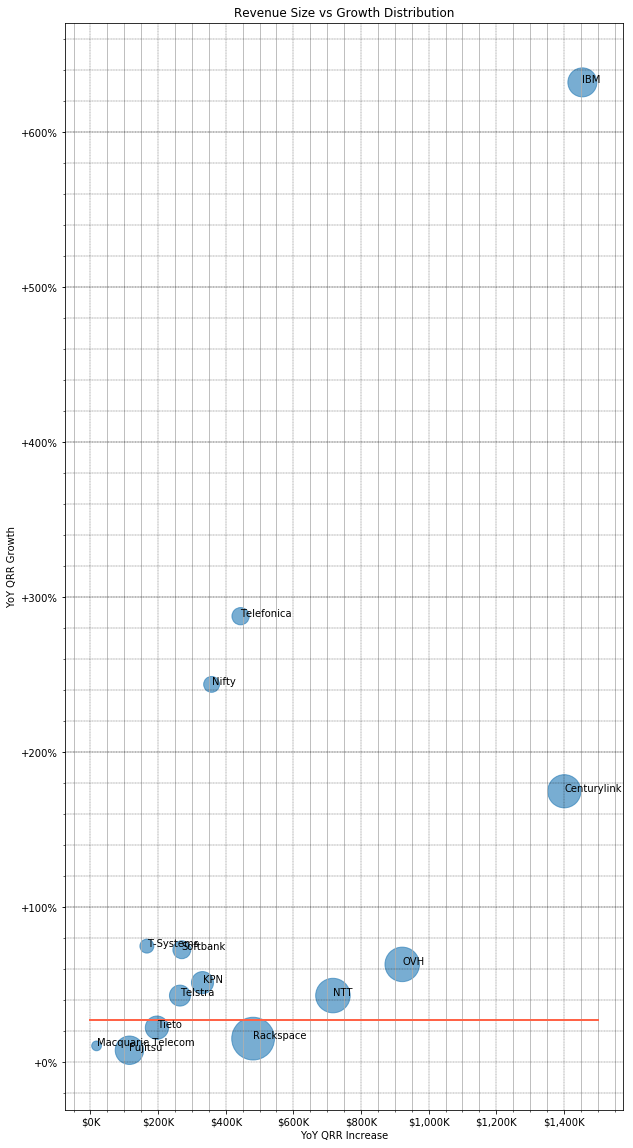

In [89]:
import size_vs_growth as sg
    
sg.plot(df[(df['Partner Status']=='Showcase')],
    {'type':['NO_SLICE'],
     'min_rev_growth':10000,
    'show_sp_name':0},group_key='Partner Group Name')

### VCPP Partners Revenue Distribution

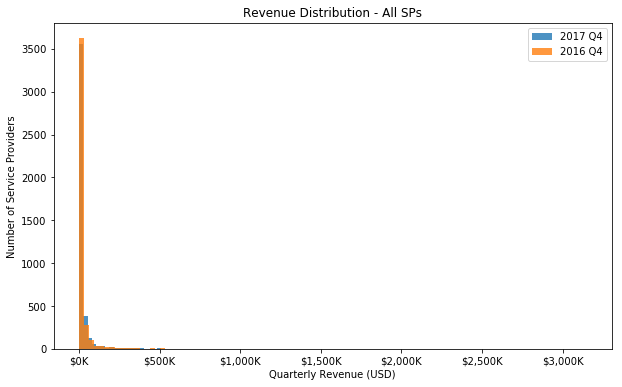

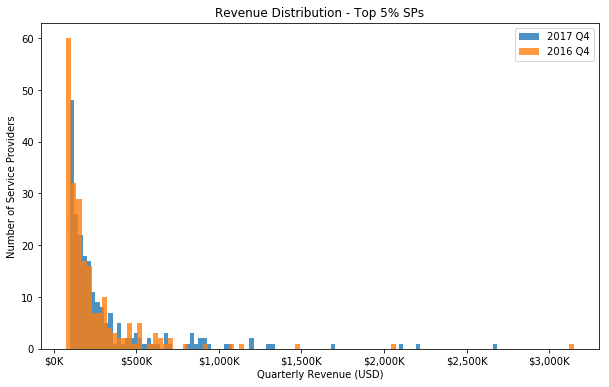

Total SP Count: 4321
Top 10 SPs Contribution: 13%
Rackspace US, Inc                    2,686,880
SAVVIS                               2,202,887
OVH                                  2,104,939
IBM                                  1,684,760
Hewlett-Packard Enterprise Company   1,320,704
Softlayer Technologies, Inc.         1,301,344
SoftLayer                            1,208,739
Internet Initiative Japan Inc.       1,200,227
Tieto Corporation                    1,081,124
Canopy the Open Cloud Company        1,033,264


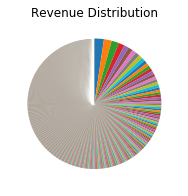

Total SP Count: 148
Top 10 SPs Contribution: 72%
Internet Initiative Japan Inc.       1,200,227
NTT Communications Corporation       946,808
Fujitsu Limited (Japan)              861,938
FUJITSU CLOUD TECHNOLOGIES LIMITED   505,271
IDC Frontier Inc.                    484,915
SoftBank Corp.                       347,004
KDDI Corporation                     229,262
NEC Corporation                      228,130
CTC/ITOCHU Techno-Solutions Corp     217,470
NS Solutions Corporation             173,871


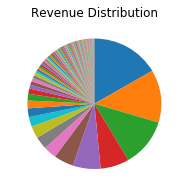

In [103]:
def df_quarter(Q):
    return df[(df['Usage Period'] >= Q[0]) & (df['Usage Period'] <= Q[2])]

def plot_hist(data_prev,data_last,cutoff,title):
    plt.hist(data_last[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2017 Q4')
    plt.hist(data_prev[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2016 Q4')

    plt.xlabel("Quarterly Revenue (USD)")
    plt.ylabel("Number of Service Providers")
    plt.title(title)
    ax = plt.gca()
    fig = plt.gcf()
    ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
    ax.legend(loc="upper right")
    fig.set_size_inches(10,6)
    plt.show()
    
df_last_q = df_quarter(END_QUARTER)
df_prev_q = df_quarter(YEAR_AGO_QUARTER)
data_last = df_last_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
data_prev = df_prev_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    
plot_hist(data_prev,data_last,1.0,"Revenue Distribution - All SPs")
plot_hist(data_prev,data_last,0.05,"Revenue Distribution - Top 5% SPs")
    
def print_pie(df):
    total_last = df['Value (USD)'].sum()
    s_sp_val = df.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    print("Total SP Count: {}".format(len(s_sp_val)))
    print("Top {} SPs Contribution: {:.0f}%".format(10,s_sp_val[:10].sum()/total_last*100))
    for sp,val in s_sp_val[:10].iteritems():
        print("{:36s} {:,.0f}".format(sp,val))
    
    plt.pie(s_sp_val.values,startangle=90,counterclock=False)
    plt.title('Revenue Distribution')
    plt.gcf().set_size_inches(3,3)
    plt.show()

print_pie(df_last_q)
print_pie(df_last_q[df_last_q['Country'] == 'Japan'])



SAVVIS                                   United States    (AMER) $ 1,401,179 (175%)
OVH                                      France           (EMEA) $   800,094 (61%)
IBM                                      United States    (AMER) $ 1,461,678 (655%)
Hewlett-Packard Enterprise Company       United States    (AMER) $   974,054 (281%)
Softlayer Technologies, Inc.             United States    (AMER) $ 1,153,187 (778%)
SoftLayer                                United Kingdom   (EMEA) $ 1,183,275 (4,647%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $   914,572 (771%)
NTT DATA Inc.                            United States    (AMER) $   737,553 (427%)
Virtustream                              United States    (AMER) $   607,959 (209%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   721,280 (513%)


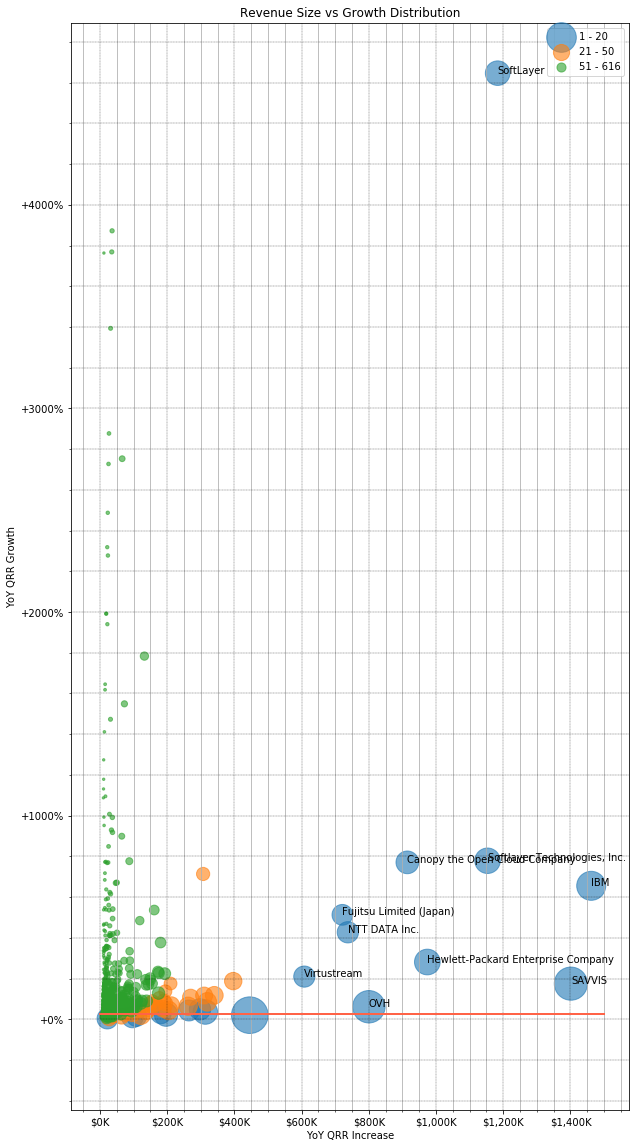

In [102]:
def df_last_q(df):
    
    
    
    s_sp_rev = df.groupby('Service Provider')
RANKS = [[1,10],[11,100],[101,1000],[1001,]]

RA

sg.plot(df,
     {'type':['RANK'],
      'time_frame': 'LAST_12',
      'min_rev_growth':10000,
      'show_sp_name':500000})

### Showcase Partner - Group Companies Revenue Trend

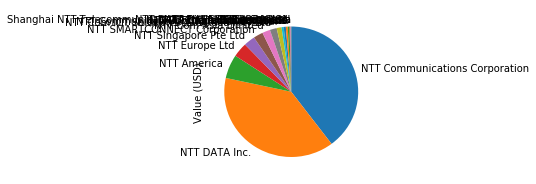

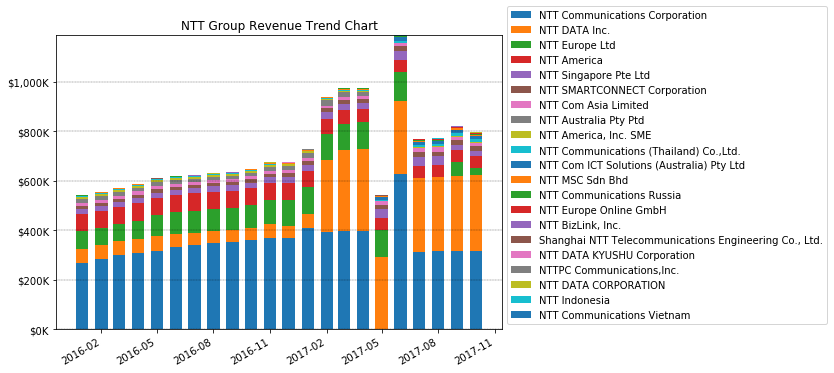

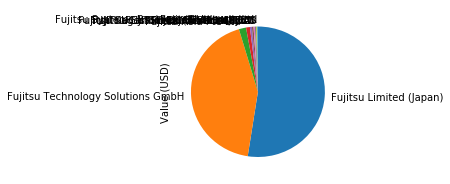

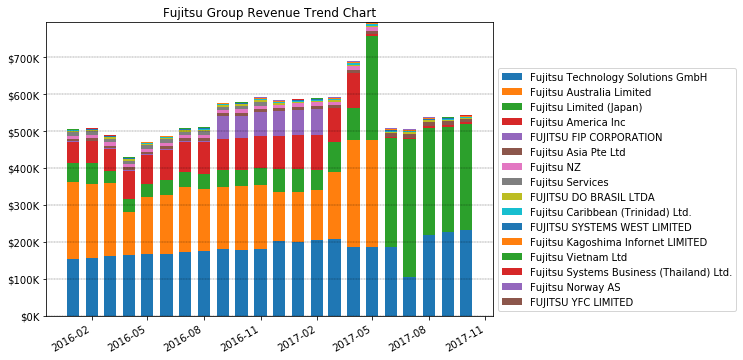

In [90]:
def partner_rev_trend(group,key='Value (USD)'):
    sp_group = df[df['Partner Group Name'] == group]

    # sort by revenue size at the last month
    sp_lm = sp_group[sp_group['Usage Period'] == END_MONTH].groupby('Service Provider')[key].sum().sort_values(ascending=False)
    
    sp_lm.plot.pie(startangle=90,counterclock=False)
    plt.gcf().set_size_inches(3,3)
    plt.show() 
    
#    sp_group = df[df['Partner Group Name'] == group]
    sp_sorted = sp_group.groupby('Service Provider')[key].sum().sort_values(ascending=False)

    # get the series of usage period
    index = sp_group.groupby('Usage Period')[key].sum().index
    
    prev_bar = 0
    for sp in sp_sorted.index:
        rev_by_period = df[df['Service Provider'] == sp].groupby('Usage Period')[key].sum() 
        for up in index:
            if not up in rev_by_period.keys():
                rev_by_period.set_value(up,0.0)
        rev_by_period = rev_by_period.sort_index()
 
        plt.bar(rev_by_period.index,rev_by_period.values,width=20,label=sp,bottom=prev_bar)
        prev_bar += rev_by_period.values
        
    format_trend_chart()

    plt.title('{} Group Revenue Trend Chart'.format(group))
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
partner_rev_trend('NTT')
partner_rev_trend('Fujitsu')


### Revenue Size vs Growth

SAVVIS                                   United States    (AMER) $ 1,401,179 (175%)
OVH                                      France           (EMEA) $   800,094 (61%)
IBM                                      United States    (AMER) $ 1,461,678 (655%)
Hewlett-Packard Enterprise Company       United States    (AMER) $   974,054 (281%)
Softlayer Technologies, Inc.             United States    (AMER) $ 1,153,187 (778%)
SoftLayer                                United Kingdom   (EMEA) $ 1,183,275 (4,647%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $   914,572 (771%)
NTT DATA Inc.                            United States    (AMER) $   737,553 (427%)
Virtustream                              United States    (AMER) $   607,959 (209%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   721,280 (513%)


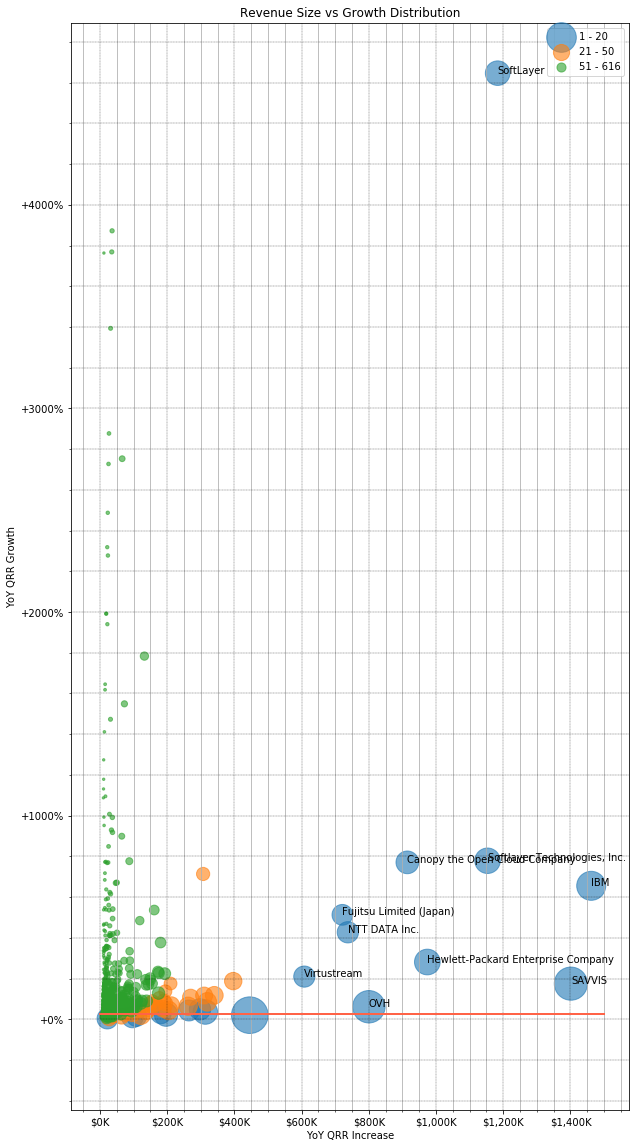

SAVVIS                                   United States    (AMER) $ 1,401,179 (175%)
IBM                                      United States    (AMER) $ 1,461,678 (655%)
Hewlett-Packard Enterprise Company       United States    (AMER) $   974,054 (281%)
Softlayer Technologies, Inc.             United States    (AMER) $ 1,153,187 (778%)
NTT DATA Inc.                            United States    (AMER) $   737,553 (427%)
Virtustream                              United States    (AMER) $   607,959 (209%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   721,280 (513%)
SoftLayer                                United Kingdom   (EMEA) $ 1,183,275 (4,647%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $   914,572 (771%)
SoftLayer                                United Kingdom   (EMEA) $ 1,183,275 (4,647%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $   914,572 (771%)


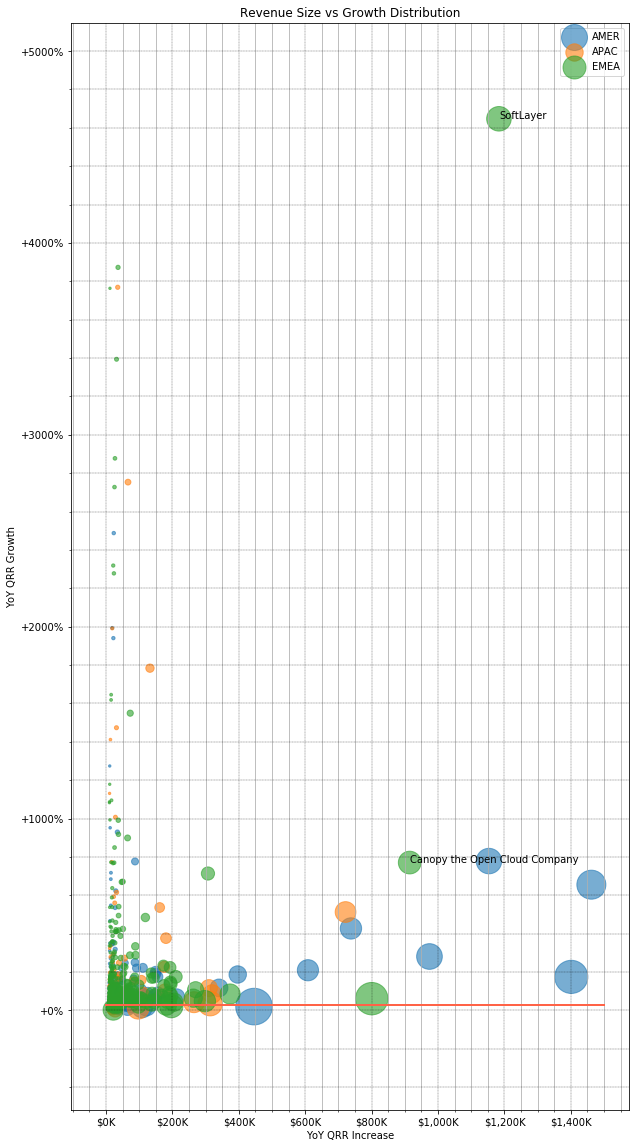

Internet Initiative Japan Inc.           Japan            (APAC) $   313,409 (35%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   721,280 (513%)
SoftBank Corp.                           Japan            (APAC) $   176,542 (104%)
KDDI Corporation                         Japan            (APAC) $   111,339 (94%)
NEC Corporation                          Japan            (APAC) $   180,262 (377%)
NS Solutions Corporation                 Japan            (APAC) $   106,547 (158%)
FreeBit Co.,Ltd.                         Japan            (APAC) $   132,168 (1,784%)


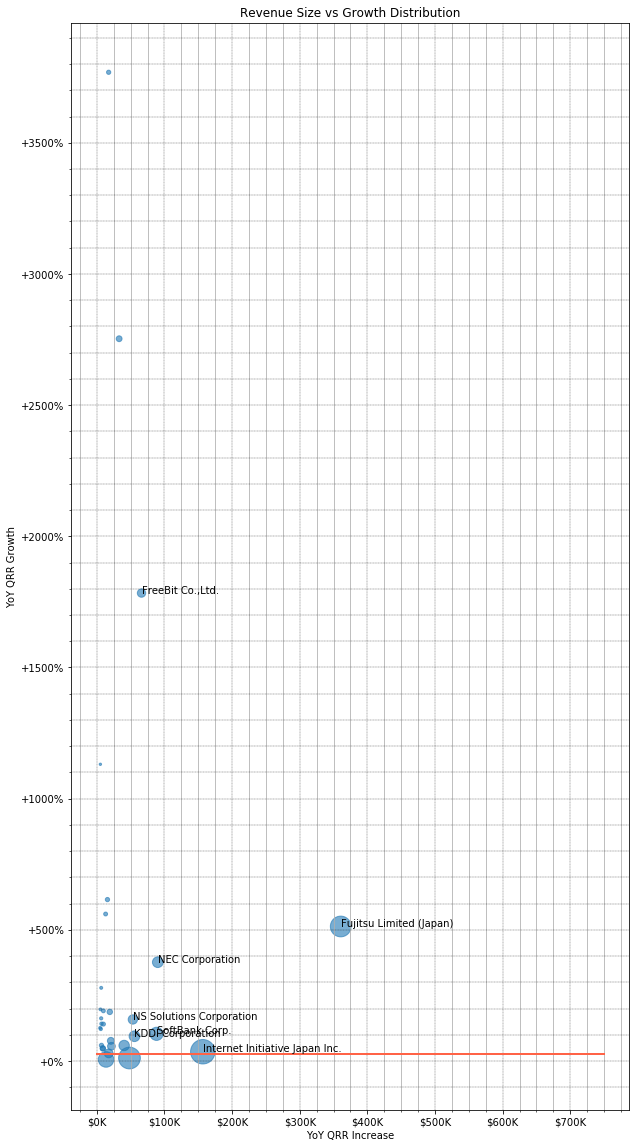

In [91]:
import size_vs_growth as sg

sg.plot(df,
     {'type':['GEO','RANK'],
      'time_frame': 'LAST_12',
      'min_rev_growth':10000,
      'show_sp_name':500000})
    
sg.plot(df[(df['Country']=='Japan')],
    {'type':['NO_SLICE'],
     'time_frame': 'LAST_12',     
     'min_rev_growth':10000,
    'show_sp_name':100000})